# Covertype

In [1]:
%load_ext autoreload
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
from jax import config
config.update("jax_debug_nans", False)
from tqdm import tqdm
from jax import config


import jax.numpy as jnp
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd
import scipy
import haiku as hk
    
import utils
import plot
import distributions
import stein
import models
import flows
from itertools import cycle, islice

key = random.PRNGKey(0)

from sklearn.model_selection import train_test_split

from functools import partial
import kernels

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
sns.set(style='white')

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

import optax

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
# set up exporting
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# save figures by using plt.savefig('title of figure')

In [3]:
%matplotlib inline

# Data

In [4]:
data = scipy.io.loadmat('/home/lauro/code/msc-thesis/wang_svgd/data/covertype.mat')
features = data['covtype'][:, 1:]
features = onp.hstack([features, onp.ones([features.shape[0], 1])]) # add intercept term

labels = data['covtype'][:, 0]
labels[labels == 2] = 0

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

num_features = features.shape[-1]
num_classes = len(onp.unique(labels))

In [5]:
default_batch_size = 500
def get_batches(x, y, n_steps=500, batch_size=default_batch_size):
    """Split x and y into batches"""
    assert len(x) == len(y)
    n = len(x)
    idxs = onp.random.choice(n, size=(n_steps, batch_size))
    for idx in idxs:
        yield x[idx], y[idx]
#     batch_cycle = cycle(zip(*[onp.array_split(data, len(data)//batch_size) for data in (x, y)]))
#     return islice(batch_cycle, n_steps)

num_batches = len(x_train) // default_batch_size

In [6]:
# def get_batches(x, y, n_steps=500, batch_size=100):
#     """Split x and y into batches"""
#     assert len(x) == len(y)
#     batch_cycle = cycle(zip(*[onp.array_split(data, len(data)//batch_size) for data in (x, y)]))
#     return islice(batch_cycle, n_steps)

# num_batches = len(x_train) // 100

In [7]:
# batches = get_batches(x_train, y_train, batch_size=5)

# Model

We can define the model using `tfd.JointDistributionCoroutine`.

### TODO file bug: gamma pdf wrong in tfd

skip assert _assert_compare_to_zero


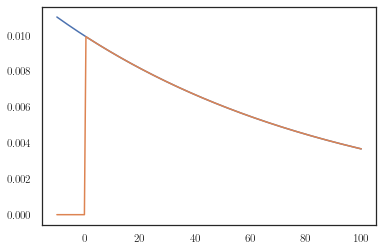

In [8]:
a0, b0 = 1, 0.01 # hyper-parameters
t = tfd.Gamma(a0, b0, validate_args=True)
gamma_pdf = lambda x: jax.scipy.stats.gamma.pdf(x, a0, 0, 1/b0)
plot.plot_fun(t.prob, lims=(-10,100))
plot.plot_fun(gamma_pdf, lims=(-10, 100))

In [9]:
a0, b0 = 1, 0.01 # hyper-parameters
# note that b0 is inverse scale, so this means alpha big, 1/alpha small! gaussian narrow! dunno why, check paper

# a0, b0 = 1, 10 # b approx equals variance

Root = tfd.JointDistributionCoroutine.Root

def get_model(features_batch):
    def model():
        """generator"""
        log_alpha = yield Root(tfd.ExpGamma(a0, b0, name="log_alpha"))                                      # scalar
        w = yield tfd.Sample(tfd.Normal(0., 1/np.exp(log_alpha/2)), sample_shape=(num_features,), name="w") # shape (num_features,)
        log_odds = jnp.dot(features_batch, w)                                                               # shape (len(features_batch),)
        _ = yield tfd.Independent(tfd.Bernoulli(logits=log_odds), name="labels")                            # shape (len(features_batch),) in {0, 1}
    return model


def get_logp(x_batch, y_batch):
    """Stochastic estimate of the log-density (up to additive constant)
    based on batch"""
    def logp(params):
        dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x_batch), validate_args=True)
        return dist.log_prob(tuple(params) + (y_batch,))
    return logp


dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x_train[:7]))
key, subkey = random.split(key)
dist.sample(seed=subkey)

StructTuple(
  log_alpha=DeviceArray(3.0338602, dtype=float32),
  w=DeviceArray([ 0.09460681,  0.41388664, -0.25374022,  0.08236972,
                 -0.18633808,  0.13434607,  0.17748527, -0.32364935,
                  0.01490305,  0.2890601 , -0.09782197,  0.42713836,
                 -0.12731986,  0.166087  ,  0.2206649 ,  0.1801842 ,
                 -0.05160215, -0.5159453 ,  0.18758786, -0.227491  ,
                 -0.17266577, -0.1659005 ,  0.40405896, -0.17637107,
                  0.3058167 ,  0.08908796,  0.40521732, -0.03048955,
                 -0.27038792,  0.22716382,  0.3779735 ,  0.02121975,
                 -0.37714285, -0.06021009,  0.14214149, -0.01613411,
                 -0.34500417,  0.15541391,  0.19098611,  0.07176194,
                 -0.00457712,  0.09145339, -0.60423875,  0.04674321,
                  0.09213234,  0.12824067,  0.15537785, -0.1141754 ,
                  0.03958449, -0.11548389, -0.19152494, -0.0089962 ,
                 -0.05483136,  0.102976

In [10]:
key, subkey = random.split(key)
_, w, labels = dist.sample(seed=subkey)
def pdf(log_alpha):
    return dist.prob((log_alpha, w, labels))

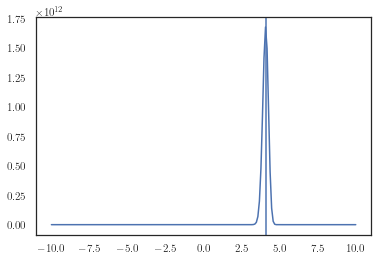

In [11]:
# plot.plot_fun(tfd.ExpGamma(a0, b0).prob, lims=(-10, 10))

plot.plot_fun(pdf, lims=(-10, 10))
log_alpha = np.log(np.var(w))
plt.axvline(x=-log_alpha) # makes sense, since 1/alpha \approx Var(w)

Note that we have two distinct types of batching going on: we're using batches of data to estimate the gradient $\nabla \log p$, and then we're mapping that gradient over a set of particles.

In [12]:
batches = get_batches(x_train, y_train, batch_size=5)
x, y = next(batches)
del batches
logp = get_logp(x, y)

dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x), validate_args=True)
*params, labels = dist.sample(seed=key)
print(dist.log_prob(params + [y]))
print(logp(params))

# now batched!
key, subkey = random.split(key)
*params, labels = dist.sample(7, seed=subkey)
print(vmap(logp)(params))
print(logp(params))

32.061127
32.061127
[35.86274  32.666737  4.223049 62.549442 28.980747 46.369236 53.683918]
[35.86274  32.666737  4.223049 62.549442 28.980747 46.369236 53.683918]


# Run inference using minibatches

We can ravel (flatten) and unravel parameters like so:

In [13]:
params = dist.sample(seed=key)[:-1]
params_flat, unravel = jax.flatten_util.ravel_pytree(params)
# unravel(params_flat) == params
# [a == b for a, b in zip(unravel(params_flat), params)]

In [15]:
def get_flat_logp(x_batch, y_batch):
    logp = get_logp(x_batch, y_batch)
    def flat_logp(params_flat):
        return logp(unravel(params_flat))
    return flat_logp

@jit
def mean_logp(x_batch, y_batch, flat_particles):
    logp = get_flat_logp(x_batch, y_batch)
    return np.mean(vmap(logp)(flat_particles))

def ravel(params):
    flat, _ = jax.flatten_util.ravel_pytree(params)
    return flat

def batch_ravel(batch):
    return vmap(ravel)(batch)

def batch_unravel(batch_flat):
    return vmap(unravel)(batch_flat)

lr schedule
$$\frac{a}{(t+1)^{0.55}}$$

In [16]:
def get_probs(params):
    """
    Argument: sampled model parameters (single sample! need to vmap over sample batch)
    Returns logits shaped (n,)"""
    test_dist = tfd.JointDistributionCoroutineAutoBatched(get_model(x_test))
    dists, _ = test_dist.sample_distributions(seed=random.PRNGKey(0), value=params + (None,))
    probs = dists[-1].distribution.probs_parameter() # spits out probability of labels
    return probs

def get_preds(params):
    """
    Argument: sampled model parameters (batch)
    Returns predictions on test set
    """
    probs = vmap(get_probs)(params) # shape (n_samples, n_data)
    return (probs.mean(axis=0) > 0.5).astype(np.int32)

@jit
def test_accuracy(params):
    """
    Argument: sampled model parameters (batch)
    Returns accuracy on test set
    """
    return np.mean(get_preds(params) == y_test)

In [17]:
# test loglikelihood
test_batches = get_batches(x_test, y_test, batch_size=5000)
xtest, ytest = next(test_batches)
@jit
def test_logp(flat_particles):
    return mean_logp(xtest, ytest, flat_particles)

In [18]:
from sklearn.calibration import calibration_curve

In [58]:
NUM_VALS = 20 # number of test accuracy evaluations per run
NUM_EPOCHS = 3
NUM_STEPS = num_batches*NUM_EPOCHS

In [ ]:
def sample(key):
    return batch_ravel(dist.sample(200, seed=key)[:-1])

In [59]:
def run_sgld(key, init_batch):
    """init_batch is a batch of initial samples / particles."""
    init_batch_flat = batch_ravel(init_batch)

    def energy_gradient(params, particles, aux=True):
        """params = [batch_x, batch_y]"""
        logp = get_flat_logp(*params)
        log_probs, grads = vmap(value_and_grad(logp))(particles)
        if aux:
            return -grads, {"logp": np.mean(log_probs)}
        else:
            return -grads

    particles = models.Particles(key, energy_gradient, init_batch_flat, learning_rate=5e-3,
                                 noise_level=1.)

    for i, batch_xy in tqdm(enumerate(get_batches(x_train, y_train, NUM_STEPS+1)), total=NUM_STEPS):
        particles.step(batch_xy)
        stepdata = {
            "accuracy": None,
            "test_logp": None
        }
        if i % (NUM_STEPS//NUM_VALS)==0:
            stepdata = {
                "accuracy": test_accuracy(batch_unravel(particles.particles.training)),
                "test_logp": test_logp(particles.particles.training),
            }
        particles.write_to_log(stepdata)
    particles.perturb()
    particles.done()
    return batch_unravel(particles.particles.training), particles

In [90]:
svgd_opt = optax.chain(optax.scale_by_schedule(utils.polynomial_schedule), 
                       optax.scale_by_rms(),
                       optax.scale(-5e-2))

def run_svgd(init_batch):
    """init_batch is a batch of initial samples / particles."""
    init_batch_flat = batch_ravel(init_batch)
    accs = []

    svgd_grad = models.KernelGradient(get_target_logp=lambda batch: get_flat_logp(*batch), scaled=True)
    particles = models.Particles(key, svgd_grad.gradient, init_batch_flat, custom_optimizer=svgd_opt)

    for i, batch in tqdm(enumerate(get_batches(x_train, y_train, NUM_STEPS+1)), total=NUM_STEPS):
        particles.step(batch)
        stepdata = {
            "accuracy": None,
            "test_logp": None,
        }
        if i % (NUM_STEPS//NUM_VALS) == 0:
            stepdata = {
                "accuracy": test_accuracy(batch_unravel(particles.particles.training)),
                "test_logp": test_logp(particles.particles.training),
            }
        particles.write_to_log(stepdata)

    particles.done()
    return batch_unravel(particles.particles.training), particles

In [91]:
svgd_opt = optax.chain(optax.scale_by_schedule(utils.polynomial_schedule), 
                       optax.scale_by_rms(),
                       optax.scale(-1e-3))

def run_neural_svgd(key, init_batch):
    """init_batch is a batch of initial samples / particles.
    Note: there's two types of things I call 'batch': a batch from the dataset
    and a batch of particles. don't confuse them"""
    init_batch_flat = batch_ravel(init_batch)

    key1, key2 = random.split(key)
    neural_grad = models.SDLearner(target_dim=init_batch_flat.shape[1],
                                   get_target_logp=lambda batch: get_flat_logp(*batch),
                                   learning_rate=5e-3,
                                   key=key1,
                                   aux=False)
    particles = models.Particles(key2, neural_grad.gradient, init_batch_flat, optimizer="sgd")

    # Warmup on first batch
    neural_grad.train(next_batch=sample, n_steps=100, early_stopping=False, data=next(get_batches(x_train, y_train, 2)))

    next_batch = partial(particles.next_batch, batch_size=2*len(init_batch_flat)//3)
    for i, data_batch in tqdm(enumerate(get_batches(x_train, y_train, NUM_STEPS+1)), total=NUM_STEPS):
        neural_grad.train(next_batch=next_batch, n_steps=10, data=data_batch)
        particles.step(neural_grad.get_params())
        stepdata = {
            "accuracy": None,
            "test_logp": None,
            "training_logp": mean_logp(*data_batch, particles.particles.training)
        }
        if i % (NUM_STEPS//NUM_VALS)==0:
            stepdata = {
                "accuracy": test_accuracy(batch_unravel(particles.particles.training)),
                "test_logp": test_logp(particles.particles.training),
            }
        particles.write_to_log(stepdata)
    neural_grad.done()
    particles.done()
    return batch_unravel(particles.particles.training), particles, neural_grad

In [62]:
key, subkey = random.split(key)

In [63]:
# TODO: check if I'm doing batching right
# cause it seems test accuracy and test likelihood don't track the 
# new batch likelihood, even tho those should be the same

In [64]:
%autoreload

In [65]:
# Run samplers
init_batch = dist.sample(200, seed=subkey)[:-1]
sgld_samples, sgld_p = run_sgld(key, init_batch)
svgd_samples, svgd_p = run_svgd(init_batch)
neural_samples, neural_p, neural_grad = run_neural_svgd(key, init_batch)

2788it [00:13, 211.99it/s]                          
2788it [02:11, 21.28it/s]                          
2788it [02:56, 15.79it/s]                          


In [66]:
sgld_aux = sgld_p.rundata
svgd_aux = svgd_p.rundata
neural_aux = neural_p.rundata

# neural rundata

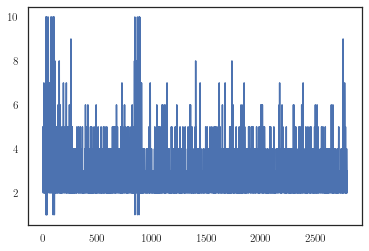

In [67]:
plt.plot(neural_grad.rundata["train_steps"])

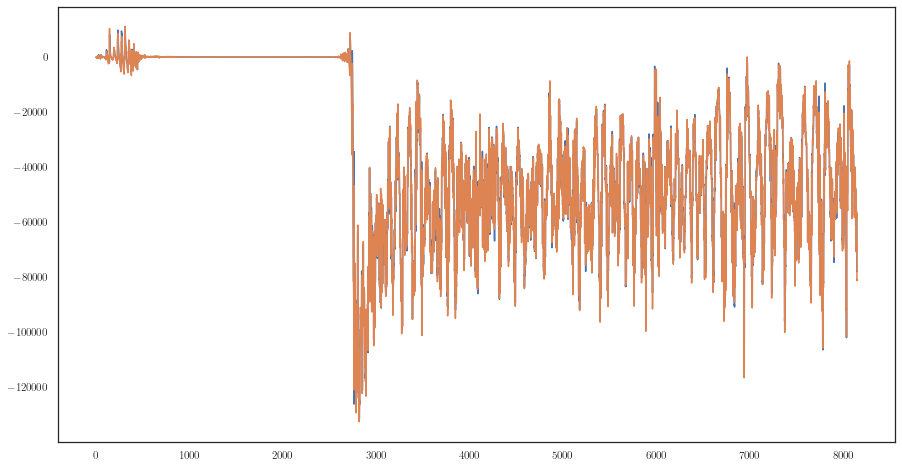

In [68]:
plt.subplots(figsize=[15, 8])
plt.plot(neural_grad.rundata["training_loss"])
plt.plot(neural_grad.rundata["validation_loss"])

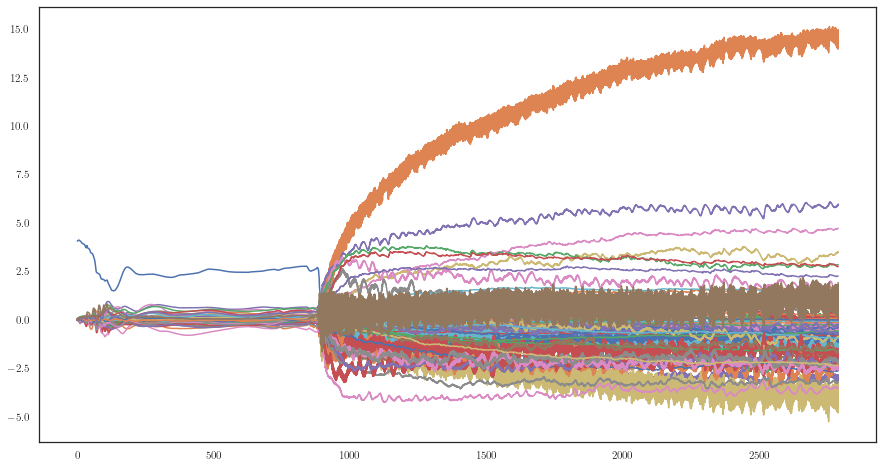

In [89]:
plt.subplots(figsize=[15, 8])
plt.plot(neural_aux["training_mean"]);

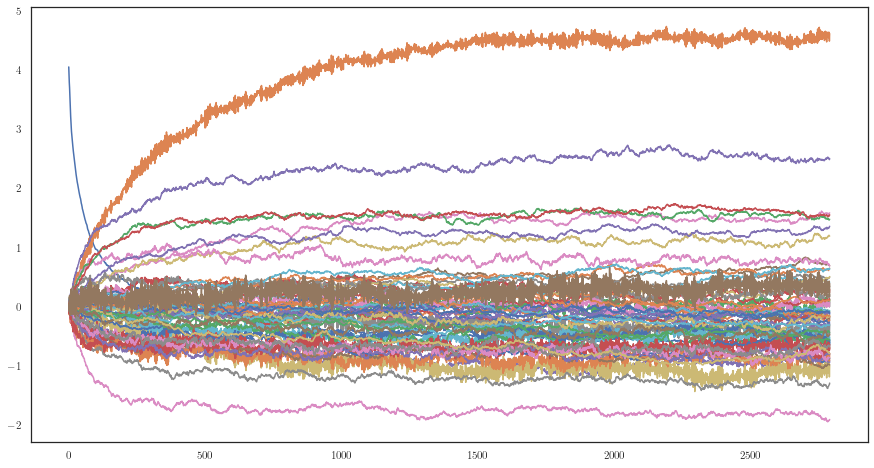

In [70]:
plt.subplots(figsize=[15, 8])
plt.plot(sgld_aux["training_mean"]);

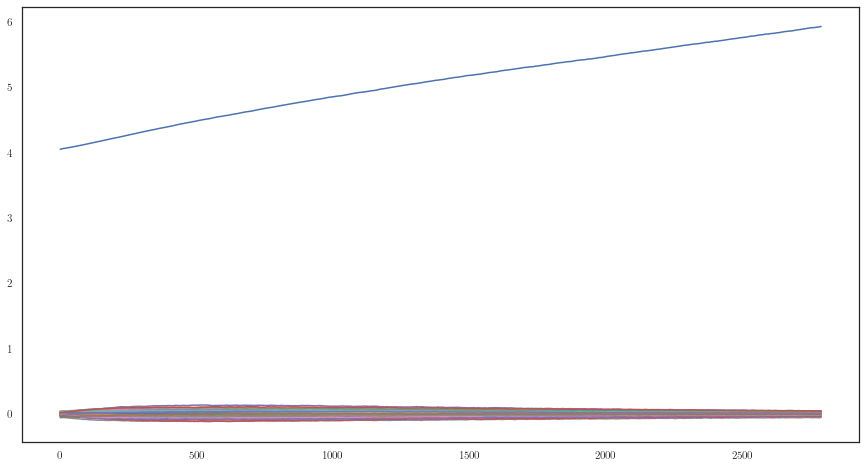

In [71]:
plt.subplots(figsize=[15, 8])
plt.plot(svgd_aux["training_mean"]);

## Evaluate samples on test set

In [72]:
sgld_accs, svgd_accs, neural_accs = [aux["accuracy"] for aux in (sgld_aux, svgd_aux, neural_aux)]

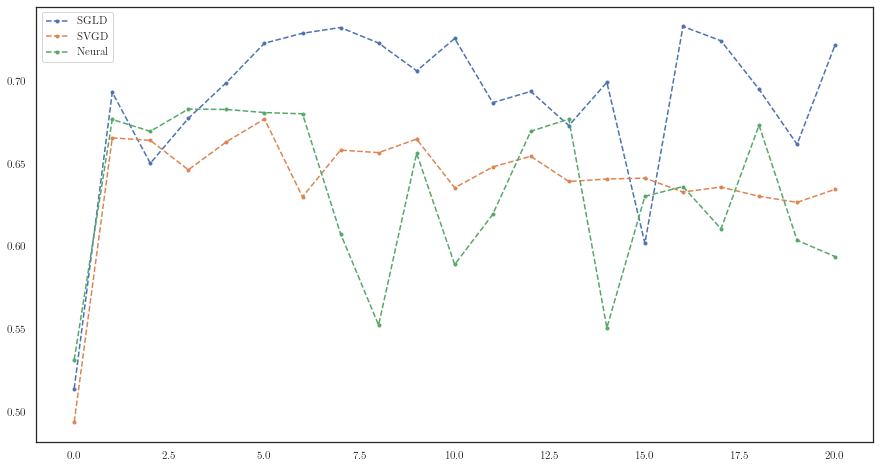

In [73]:
plt.subplots(figsize=[15, 8])
names = ["SGLD", "SVGD", "Neural"]
accs = [sgld_accs, svgd_accs, neural_accs]
for name, acc in zip(names, accs):
    acc = onp.array(acc)
    plt.plot(acc[np.isfinite(acc.astype(np.double))], "--.", label=name)
plt.legend()

In [74]:
print("SGLD accuracy:", test_accuracy(sgld_samples))
print("SVGD accuracy:", test_accuracy(svgd_samples))
print("Neural accuracy:", test_accuracy(neural_samples))
key, subkey = random.split(key)
print("Prior samples accuracy:", test_accuracy(dist.sample(500, seed=subkey)[:-1]))
print("Balance:", np.mean(y_test))

SGLD accuracy: 0.7150332
SVGD accuracy: 0.6313176
Neural accuracy: 0.6005008
Prior samples accuracy: 0.47255233
Balance: 0.5137819


### compute log-likelihoods (train and test)

In [75]:
test_batches = get_batches(x_test, y_test, batch_size=5000)

In [76]:
x, y = next(test_batches)
test_logps = [mean_logp(x, y, batch_ravel(samples)) for samples in (sgld_samples, svgd_samples, neural_samples)]

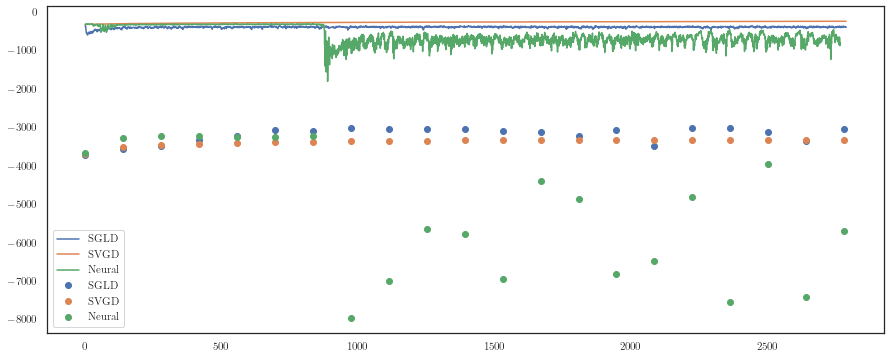

In [77]:
plt.subplots(figsize=[15, 6])
plt.plot(sgld_aux["training_logp"], label="SGLD")
plt.plot(onp.mean(svgd_aux["training_logp"], axis=1), label="SVGD")
plt.plot(neural_aux["training_logp"], label="Neural")
# plt.ylim((-1500, -400))

lines = plt.gca().get_lines()
colors = [line.get_color() for line in lines]
names = ["SGLD", "SVGD", "Neural"]
logps = [aux["test_logp"] for aux in (sgld_aux, svgd_aux, neural_aux)]
for name, lp, color in zip(names, logps, colors):
    plt.plot(lp, "o", label=name, color=color)

plt.legend()

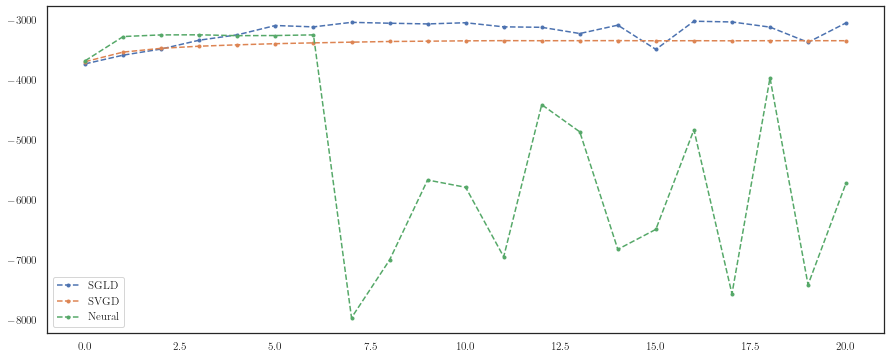

In [78]:
# Test accuracy
plt.subplots(figsize=[15, 6])
names = ["SGLD", "SVGD", "Neural"]
logps = [aux["test_logp"] for aux in (sgld_aux, svgd_aux, neural_aux)]
for name, lp in zip(names, logps):
    lp = onp.array(lp)
    plt.plot(lp[np.isfinite(lp.astype(np.double))], "--.", label=name)
plt.legend()

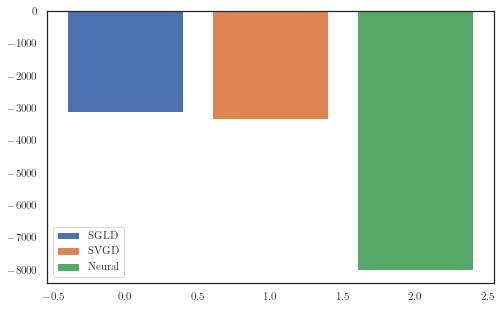

In [79]:
fig, ax = plt.subplots(figsize=[8, 5])

for i, meanlp in enumerate(test_logps):
    ax.bar(i, meanlp, label=names[i])

# ax.bar(i+1, mean_logp(x, y, batch_ravel(init_batch)), label="Init")
plt.legend()

# calibration curve

In [80]:
from sklearn.calibration import calibration_curve

In [81]:
# a, b = calibration_curve(y_test, probs)

In [82]:
@jit
def batch_probs(param_batch):
    """Returns test probabilities P(y=1) for
    all y in the test set"""
    return np.mean(vmap(get_probs)(param_batch), axis=0)

In [83]:
probabilities = [batch_probs(samples) for samples in (sgld_samples, svgd_samples, neural_samples)]

In [84]:
probabilities[1].min()

DeviceArray(0.48057222, dtype=float32)

In [85]:
probabilities[0]

DeviceArray([0.8008813 , 0.32863593, 0.16334568, ..., 0.25856847,
             0.28652456, 0.8238625 ], dtype=float32)

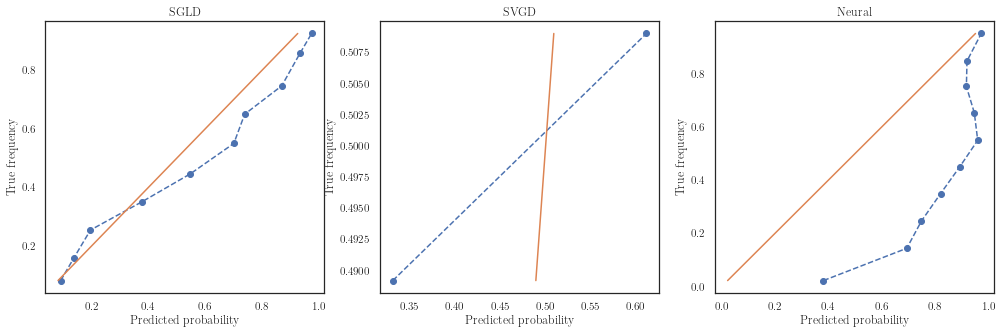

In [86]:
fig, axs = plt.subplots(1, 3, figsize=[17, 5])

for ax, probs, name in zip(axs, probabilities, names):
    true_freqs, bins = calibration_curve(y_test, probs, n_bins=10)
    ax.plot(true_freqs, bins, "--o")
#     print(bins)
    ax.plot(bins, bins)
    ax.set_ylabel("True frequency")
    ax.set_xlabel("Predicted probability")
    ax.set_title(name)

# Plot accuracy vs. certainty

In [87]:
certainty = np.max([1 - probs, probs])


TypeError: max requires ndarray or scalar arguments, got <class 'list'> at position 0.